In [74]:
from absl import logging

# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
from pigeonXT import annotate

from IPython.display import display, Image

import tensorflow_hub as hub
import pigeonXT as pixt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import json
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [75]:
with open("requirements1.json") as datafile1:
  data1 = json.load(datafile1)
dataframe1 = pd.DataFrame(data1)
# dataframe1

In [76]:
with open("requirements2.json") as datafile2:
  data2 = json.load(datafile2)
dataframe2 = pd.DataFrame(data2)
# dataframe2

In [77]:
def embed_useTensorFlow(module):
    with tf.Graph().as_default():
        sentences = tf.placeholder(tf.string)
        embed = hub.load(module)
        embeddings = embed(sentences)
        session = tf.train.MonitoredSession()
    return lambda x: session.run(embeddings, {sentences: x})

In [78]:
model = embed_useTensorFlow("/home/universal-sentence-encoder")
warnings.filterwarnings("ignore")

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [79]:
message_embeddings1 = model(dataframe1.title)
message_embeddings1

array([[ 0.02028429, -0.04547504,  0.0008653 , ..., -0.03019486,
        -0.02359271, -0.03768106],
       [-0.02782308, -0.02442297,  0.01386481, ..., -0.02604604,
         0.01534363, -0.04422351],
       [-0.03607358,  0.06149342,  0.03570342, ...,  0.02274202,
         0.0043596 , -0.02052143],
       ...,
       [-0.02979807, -0.06329199,  0.01207912, ...,  0.07824194,
        -0.0388526 , -0.03307635],
       [-0.06045128, -0.00204545,  0.02656927, ...,  0.00764415,
        -0.02669661,  0.05110301],
       [-0.08415683, -0.08687921,  0.03446119, ..., -0.01439388,
        -0.04546221,  0.03639965]], dtype=float32)

In [80]:
message_embeddings2 = model(dataframe2.title)
message_embeddings2

array([[ 0.02028429, -0.04547504,  0.0008653 , ..., -0.03019486,
        -0.02359271, -0.03768106],
       [ 0.01795929, -0.00823687, -0.08146156, ..., -0.02089699,
        -0.07995155, -0.06638795],
       [-0.04417747,  0.00145734,  0.01731091, ..., -0.04255265,
         0.03592286, -0.0454901 ],
       ...,
       [-0.05818995, -0.02438042,  0.03435886, ..., -0.00431371,
        -0.03016969, -0.04553239],
       [-0.08409847, -0.0898385 ,  0.0377935 , ..., -0.01113907,
        -0.04574325,  0.01797723],
       [ 0.01268492, -0.04417375,  0.02137297, ...,  0.0288733 ,
        -0.02806583, -0.05805147]], dtype=float32)

### Finding sentences based on similarity above certain threshold

In [81]:
tempCorr = np.inner(message_embeddings1, message_embeddings2)
tempCorr

array([[ 0.9999997 ,  0.07792404,  0.7443838 ,  0.09288538,  0.08232927,
         0.07054323,  0.33740467,  0.13678169,  0.21238796,  0.25534543,
         0.07176749],
       [ 0.8014913 ,  0.01973315,  0.88981485,  0.09399641,  0.13491908,
         0.0751824 ,  0.42811078,  0.17599285,  0.25800347,  0.13465133,
         0.00482215],
       [ 0.5202484 , -0.00840861,  0.68462336,  0.03411632,  0.11299965,
         0.07376471,  0.24897552,  0.14437759,  0.17530848,  0.21923253,
         0.0441826 ],
       [ 0.09288538,  0.11946881,  0.06602791,  0.99999994,  0.20761734,
         0.35555333,  0.08064336,  0.06445041,  0.11921951,  0.00990805,
         0.068648  ],
       [ 0.12269989, -0.08334166,  0.21776892,  0.1842165 ,  0.70689696,
         0.2676028 ,  0.08333237,  0.04023584,  0.0917294 ,  0.01661144,
        -0.0237715 ],
       [ 0.08146903,  0.12461116,  0.10275266,  0.28097314,  0.2773878 ,
         0.8816458 ,  0.05252626,  0.13999027,  0.07620304,  0.1377646 ,
         0.103

In [82]:
# Find indexes where value is greater than certain threshold
req_index = np.argwhere(tempCorr > 0.8)
req_index

array([[ 0,  0],
       [ 1,  0],
       [ 1,  2],
       [ 3,  3],
       [ 5,  5],
       [ 7,  7],
       [10,  9]])

In [83]:
for i in req_index:
    print(".....")
    print(dataframe1.values[i[0]])
    print(dataframe2.values[i[1]])

.....
['I like my phone']
['I like my phone']
.....
['My phone is good.']
['I like my phone']
.....
['My phone is good.']
['My cellphone is very good.']
.....
['Will it snow tomorrow?']
['Will it snow tomorrow?']
.....
['Global warming is real']
['Is global warming real?']
.....
['Eating strawberries is healthy']
['Eating strawberries is healthy']
.....
['what is your age?']
['Tell me your age?']


### Find unique sentences within a single file

In [84]:
#It takes similarity matrix (generated from sentence encoder) as input and gives index of redundant statements
def redundant_sent_idx(sim_matrix):
    dup_idx = [] 
    for i in range(sim_matrix.shape[0]):
        if i not in dup_idx:
            tmp = [t+i+1 for t in list(np.where( sim_matrix[i][i+1:] > 0.6 )[0])]
            dup_idx.extend(tmp)
    return dup_idx

> Check uniques values for all files

In [85]:
message_embeddings1 = model(dataframe1.title)

In [86]:
#indexes of duplicate statements.
dup_indexes1  = redundant_sent_idx(np.inner(message_embeddings1, message_embeddings1))
print(dup_indexes1)
# Now delete the dup_indexes from the dataframe
unique_messages1 = np.delete(np.array(dataframe1.title), dup_indexes1)
unique_messages1

[1, 10]


array(['I like my phone', 'Your cellphone looks great.',
       'Will it snow tomorrow?',
       'Recently a lot of hurricanes have hit the US',
       'Global warming is real', 'An apple a day, keeps the doctors away',
       'Eating strawberries is healthy', 'Is paleo better than keto?',
       'How old are you?'], dtype=object)

In [87]:
message_embeddings2 = model(dataframe2.title)

In [88]:
dup_indexes2  = redundant_sent_idx(np.inner(message_embeddings2, message_embeddings2))
print(dup_indexes2)
unique_messages2 = np.delete(np.array(dataframe2.title), dup_indexes2)
unique_messages2

[2]


array(['I like my phone', 'Let play football', 'Will it snow tomorrow?',
       'US is again hit by hurricane', 'Is global warming real?',
       'Apple is very good for health', 'Eating strawberries is healthy',
       'Is apple better than orange?', 'Tell me your age?',
       'When were you born?'], dtype=object)

In [89]:
unique_messages1_embeddings = model(unique_messages1)
unique_messages2_embeddings = model(unique_messages2)

### Find unique sentences in two files

In [90]:
corelation = np.inner(unique_messages1_embeddings, unique_messages2_embeddings)
corelation

array([[ 0.9999997 ,  0.07792404,  0.09288538,  0.08232927,  0.07054323,
         0.33740467,  0.13678169,  0.21238792,  0.25534543,  0.07176749],
       [ 0.5202484 , -0.00840861,  0.03411632,  0.11299965,  0.07376471,
         0.24897552,  0.14437759,  0.17530844,  0.21923253,  0.0441826 ],
       [ 0.09288538,  0.11946881,  0.99999994,  0.20761734,  0.35555333,
         0.08064336,  0.06445041,  0.1192195 ,  0.00990805,  0.068648  ],
       [ 0.12269989, -0.08334166,  0.1842165 ,  0.70689696,  0.2676028 ,
         0.08333237,  0.04023584,  0.09172942,  0.01661144, -0.0237715 ],
       [ 0.08146903,  0.12461116,  0.28097314,  0.2773878 ,  0.8816458 ,
         0.05252626,  0.13999027,  0.07620305,  0.1377646 ,  0.10331045],
       [ 0.20046483,  0.14315306,  0.07407309,  0.05201081,  0.00267745,
         0.6069179 ,  0.32847518,  0.40608853,  0.07179151, -0.03766647],
       [ 0.13678172,  0.15575191,  0.06445037,  0.07369408,  0.18175116,
         0.44694072,  1.        ,  0.24123523

In [91]:
# Find indexes where value is greater than certain threshold
req_index = np.argwhere(corelation > 0.6)
df1_index = []
df2_index = []
ultimate_message = []
for i in req_index:
    if i[0] not in df1_index:
        df1_index.append(i[0])
        ultimate_message.append(unique_messages1[i[0]]) #Just picked the message from first file
    if i[1] not in df2_index:    
#         print("Skipped Messages from 2nd: " + unique_messages2[i[1]])
        df2_index.append(i[1]) 

In [92]:
ultimate_message

['I like my phone',
 'Will it snow tomorrow?',
 'Recently a lot of hurricanes have hit the US',
 'Global warming is real',
 'An apple a day, keeps the doctors away',
 'Eating strawberries is healthy',
 'How old are you?']

In [93]:
# Find indexes where value is less than certain threshold
req_index = np.argwhere(corelation < 0.4)
for i in req_index:
    if i[0] not in df1_index:
        df1_index.append(i[0])
        print("From 1st file")
        print(dataframe1.values[i[0]])
        ultimate_message.append(unique_messages1[i[0]])
    if i[1] not in df2_index:
        df2_index.append(i[1])
        print("From 2nd file")
        print(dataframe2.values[i[1]])
        ultimate_message.append(unique_messages2[i[1]])

From 2nd file
['Let play football']
From 2nd file
['Eating strawberries is healthy']
From 2nd file
['Tell me your age?']
From 1st file
['My phone is good.']
From 1st file
['Eating strawberries is healthy']


In [94]:
ultimate_message

['I like my phone',
 'Will it snow tomorrow?',
 'Recently a lot of hurricanes have hit the US',
 'Global warming is real',
 'An apple a day, keeps the doctors away',
 'Eating strawberries is healthy',
 'How old are you?',
 'Let play football',
 'Is apple better than orange?',
 'When were you born?',
 'Your cellphone looks great.',
 'Is paleo better than keto?']

Text(0.5, 1.0, 'Semantic Textual Similarity')

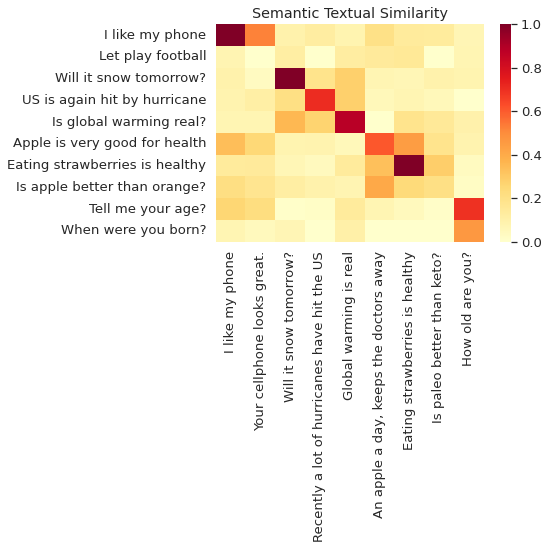

In [95]:
corr = np.inner(unique_messages2_embeddings, unique_messages1_embeddings)
# print(corr)
sns.set(font_scale=1.2)
g = sns.heatmap(
  corr,
  xticklabels=unique_messages1,
  yticklabels=unique_messages2,
  vmin=0,
  vmax=1,
  cmap="YlOrRd")
g.set_xticklabels(unique_messages1, rotation=90)
g.set_title("Semantic Textual Similarity")